In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Setting display parameters

pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

# Setting dataset root path:
root_dataset = "datasets" # if you want to work on your own  chbge[fiusdhgfblidsugf]

# Preprocessing

## Data Imports

In [3]:
df_cards = pd.read_csv(f"{root_dataset}/cards_data.csv")
df_users = pd.read_csv(f"{root_dataset}/users_data.csv")
transaction_df = pd.read_csv(f"{root_dataset}/transactions_data.csv")
mcc_df = pd.read_json(f"{root_dataset}/mcc_codes.json", typ='series').reset_index().rename(columns={"index": "mcc", 0: "description"})
train_df = pd.read_json(f"{root_dataset}/train_fraud_labels.json").reset_index().rename(columns={"index": "id"})

## Data Preprocessing

### Card and Users Directory

In [4]:
columns = ["per_capita_income", "yearly_income", "total_debt"]

for col in columns:
    df_users[col] = df_users[col].str.replace("$", "").astype("float32")

In [5]:
cards_users = df_cards.join(df_users.rename(columns={"id": "client_id"}).set_index("client_id"), on="client_id", how="left", lsuffix="left", rsuffix="right").rename(columns={"id": "card_id"})

In [6]:
cards_users.head()

,card_id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5


### MCC and Transactions Directory

In [7]:
mcc_transaction = transaction_df.join(mcc_df.set_index("mcc"), on="mcc", how="left")
mcc_transaction["amount"] = mcc_transaction["amount"].str.replace("$", "").astype("float")

In [8]:
mcc_transaction_df = mcc_transaction.merge(train_df, "inner")

In [9]:
mcc_transaction_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,Miscellaneous Food Stores,No
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,Department Stores,No
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,Money Transfer,No
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,Drinking Places (Alcoholic Beverages),No
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,NaN,Book Stores,No


# Fraud Preprocessing

In [10]:
fraud_df = mcc_transaction_df[mcc_transaction_df["target"] == "Yes"].fillna("Unknown").sort_values("client_id")
not_fraud_df = mcc_transaction_df.drop(fraud_df.index, axis=0)

In [11]:
fraud_df["abs_amount_value"] = abs(fraud_df["amount"])
unique_card_id = fraud_df["card_id"].unique()
matching_indices = []

for card in unique_card_id:
    temp_df = fraud_df[fraud_df["card_id"] == card]
    grouped = temp_df.groupby("abs_amount_value")

    for val, group in grouped:
        if (group["amount"] > 0).any() and (group["amount"] < 0).any():
            # Add the indices of both + and - rows
            matching_indices.extend(group.index.tolist())



In [12]:
final_fraud_df = fraud_df.drop(matching_indices, axis=0)

In [14]:
not_fraud_df["abs_amount_value"] = abs(not_fraud_df["amount"])
unique_card_id = not_fraud_df["card_id"].unique()
matching_indices = []

for card in unique_card_id:
    temp_df = not_fraud_df[not_fraud_df["card_id"] == card]
    grouped = temp_df.groupby("abs_amount_value")

    for val, group in grouped:
        if (group["amount"] > 0).any() and (group["amount"] < 0).any():
            # Add the indices of both + and - rows
            matching_indices.extend(group.index.tolist())


KeyboardInterrupt: 

In [23]:
final_not_fraud_df = not_fraud_df.drop(matching_indices, axis=0)

# Analysis

In [ ]:
# fraud_df = final_fraud_df
# not_fraud_df = final_not_fraud_df
# mcc_transaction_df = final_mcc_trans_df
# cards_users_df = cards_users

In [32]:
analysis_fraud_df = final_fraud_df.merge(cards_users, 'inner', on="card_id")
analysis_not_fraud_df = final_not_fraud_df.merge(cards_users, "inner", on="card_id")

### Card Type

<Axes: xlabel='card_type', ylabel='count'>

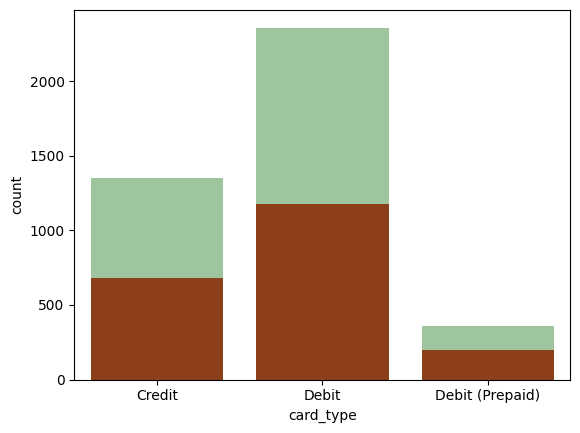

In [36]:
sns.countplot(analysis_fraud_df.drop_duplicates("card_id"), x="card_type", color="red")
sns.countplot(analysis_not_fraud_df.drop_duplicates("card_id"), x="card_type", color="green", alpha=0.4)

### Amount

<Axes: xlabel='amount', ylabel='Count'>

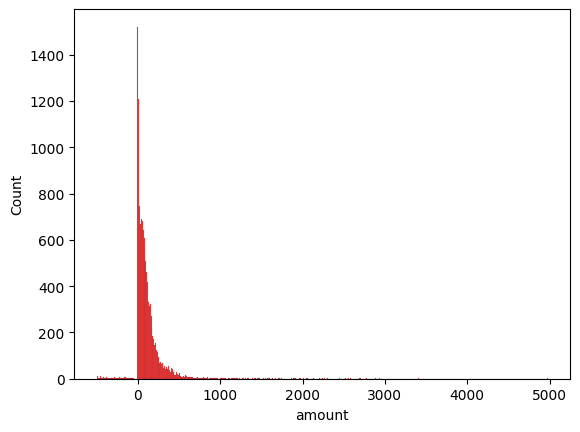

In [ ]:
sns.histplot(analysis_fraud_df, x="amount", color="red", label="Fraud")
# sns.histplot(final_not_fraud_df, x="amount", color="green", alpha=0.7, label="Not Fraud")

### Card Brand

<Axes: xlabel='card_brand', ylabel='count'>

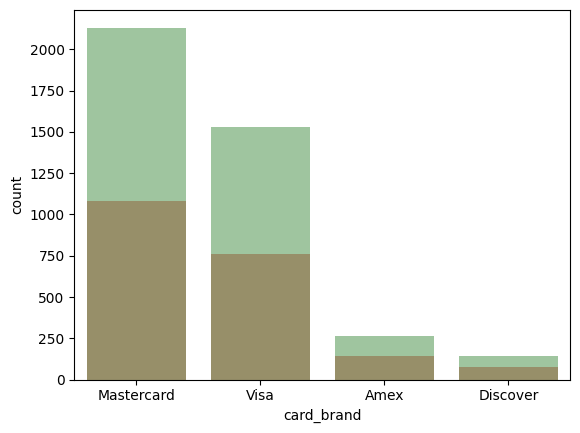

In [ ]:
sns.countplot(analysis_fraud_df.drop_duplicates("card_id"), x="card_brand", color="red", alpha=0.4)
sns.countplot(analysis_not_fraud_df.drop_duplicates("card_id"), x="card_brand", color="green", alpha=0.4)

### Age (Fraud)

<Axes: xlabel='current_age', ylabel='Count'>

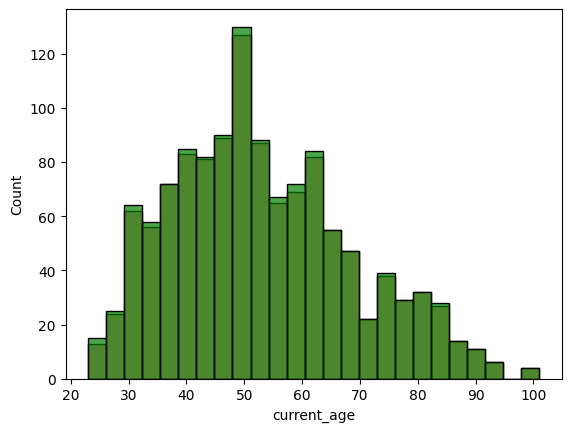

In [40]:
sns.histplot(analysis_fraud_df.drop_duplicates("client_id_x"), x="current_age", bins=25, alpha=0.4, color="red")
sns.histplot(analysis_not_fraud_df.drop_duplicates("client_id_x"), x="current_age", bins=25, color="green", alpha=0.7)

### Gender (Fraud)

<Axes: xlabel='gender', ylabel='count'>

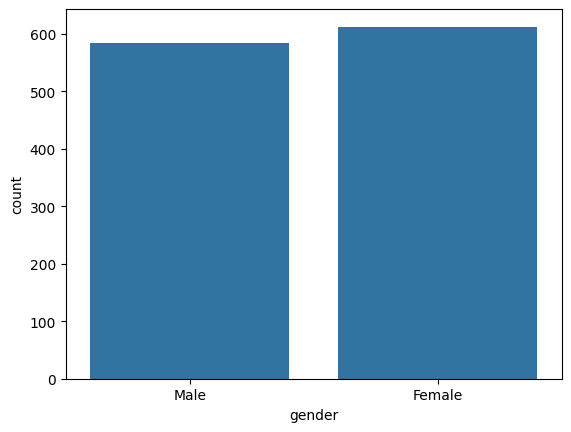

In [ ]:
sns.countplot(analysis_fraud_df.drop_duplicates("client_id_x"), x="gender")

### Description (Fraud)

In [ ]:
desc = pd.DataFrame(analysis_fraud_df["description"].value_counts()[:5])
desc

,count
description,
Department Stores,2251
Wholesale Clubs,991
Discount Stores,859
Money Transfer,725
Drug Stores and Pharmacies,479


## Fraud Labels Analysis

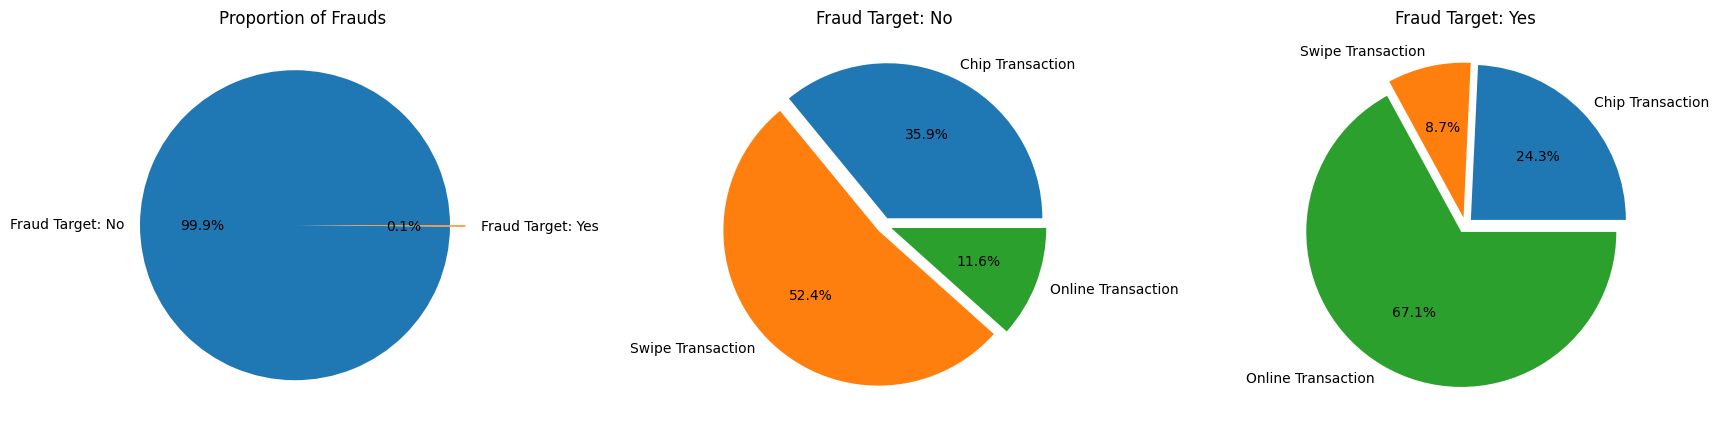

In [13]:
# What is the proportion of fraudulent transactions compared to the non-fraudulent transactions? 

# How were the fraudulent transactions committed?



fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

e = (0.05, 0.05, 0.05)



ax1.pie([8901631, 13332], labels=["Fraud Target: No", "Fraud Target: Yes"], autopct='%1.1f%%', explode=(0.05, 0.05))

ax1.set_title("Proportion of Frauds")



labels = "Chip Transaction", "Swipe Transaction", "Online Transaction" 

nums = [3199600, 4666835, 1035196]

ax2.pie(nums, labels=labels, autopct='%1.1f%%', explode=e)

ax2.set_title("Fraud Target: No")



nums = [3176, 1137, 8779]

ax3.pie(nums, labels=labels, explode=e, autopct='%1.1f%%')

ax3.set_title("Fraud Target: Yes")



plt.subplots_adjust(wspace=0.5)

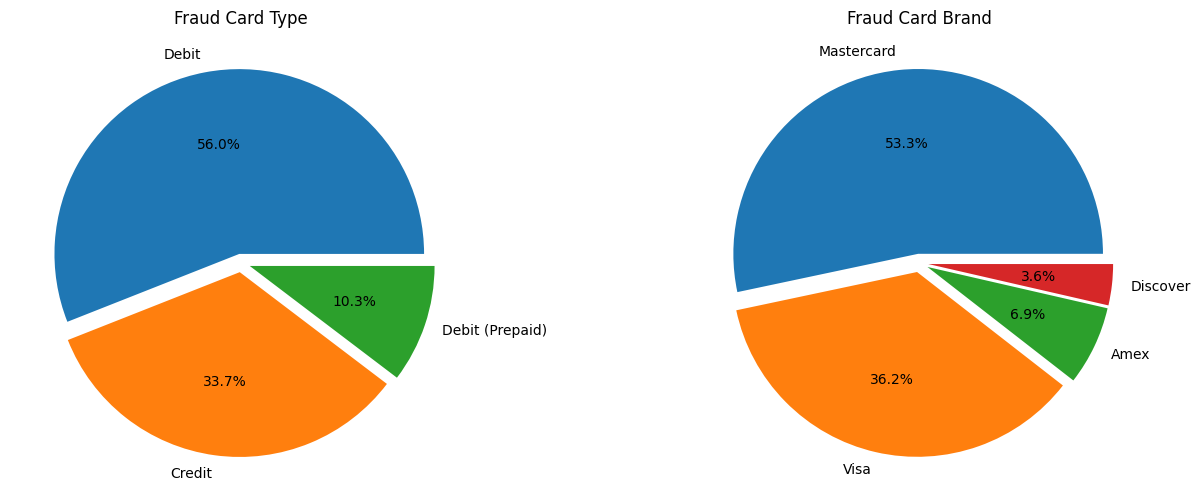

In [14]:
# What types of cards were used to cause fraudulent activities?



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))



labels = tuple(temp_yes["card_type"].value_counts().keys())

nums = temp_yes["card_type"].value_counts().values

ax1.pie(nums, labels=labels, autopct='%1.1f%%', explode=e)

ax1.set_title("Fraud Card Type")



labels = tuple(temp_yes["card_brand"].value_counts().keys())

nums = temp_yes["card_brand"].value_counts().values

ax2.pie(nums, labels=labels, autopct='%1.1f%%', explode=(0.05, 0.05, 0.05, 0.05))

ax2.set_title("Fraud Card Brand")



plt.subplots_adjust(wspace=0.4)

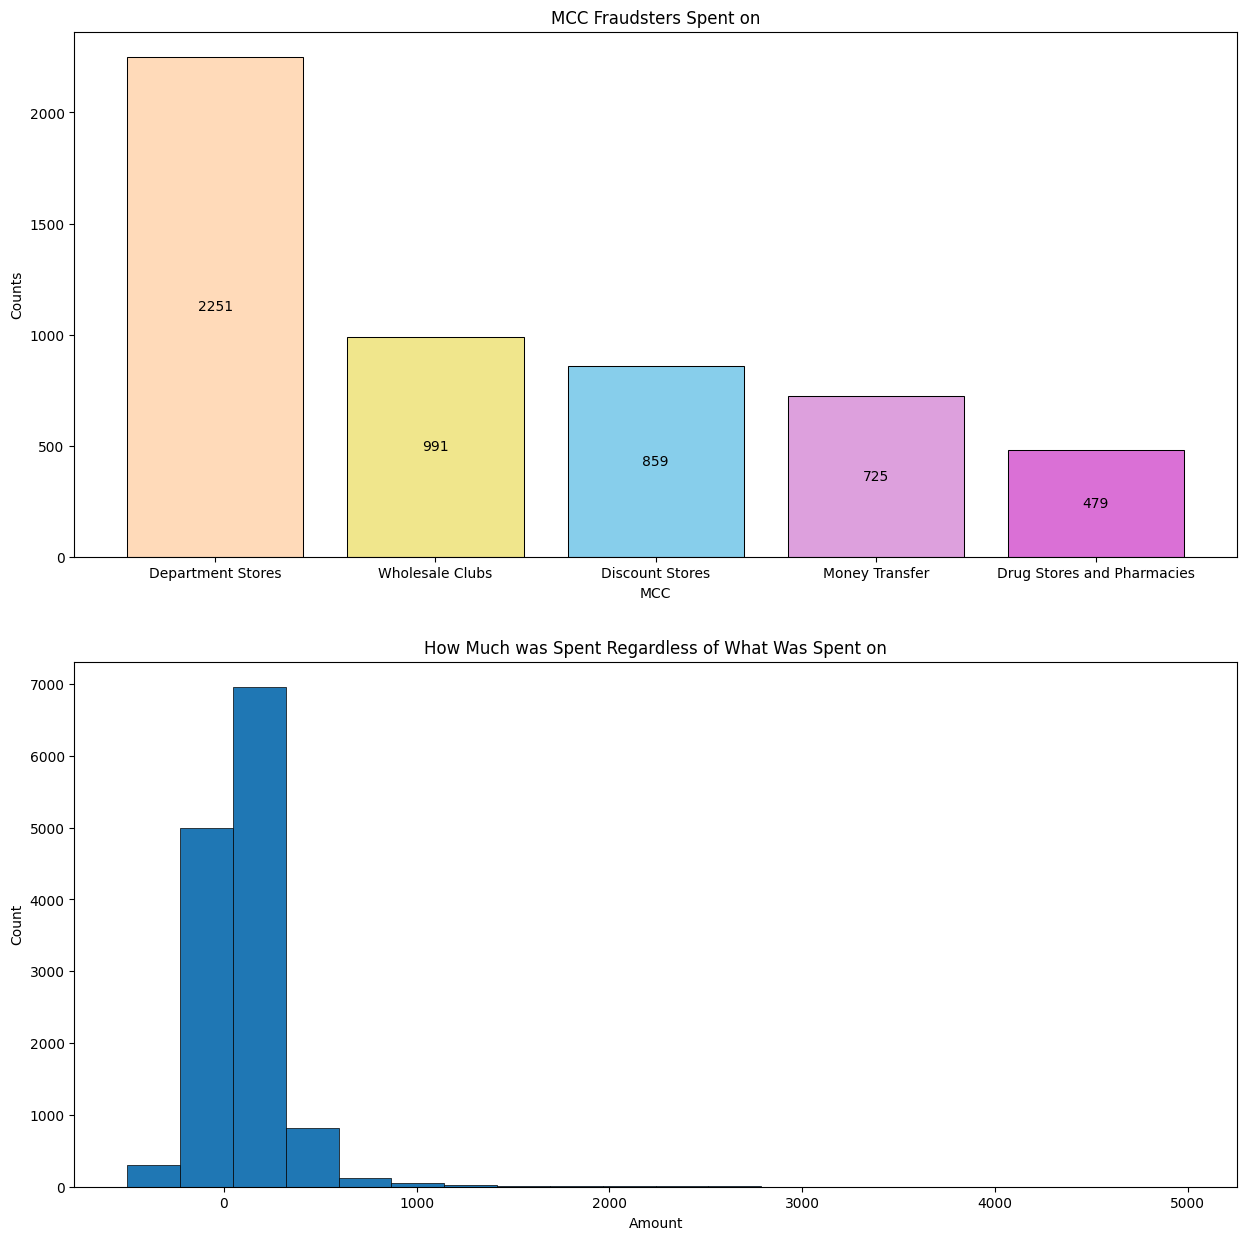

In [15]:
# What were the cards spent on?



keys = temp_yes["description"].value_counts().keys().to_list()[:5]

values = temp_yes["description"].value_counts().values.tolist()[:5]



some_dict = {"name": keys, "number": values}



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

bar = ax1.bar(some_dict["name"], some_dict["number"], color= ["peachpuff", "khaki","skyblue","plum","orchid"], linewidth=0.75, edgecolor="black")

ax1.set_title("MCC Fraudsters Spent on")

ax1.set_xlabel("MCC")

ax1.set_ylabel("Counts")

ax1.bar_label(bar, label_type="center")



ax2.hist(temp_yes["amount"], edgecolor="black", linewidth=0.5, bins=20)

ax2.set_title("How Much was Spent Regardless of What Was Spent on")

ax2.set_xlabel("Amount")

ax2.set_ylabel("Count")

plt.show()

In [16]:
temp_yes[temp_yes["amount"] == temp_yes["amount"].max()]

,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,target,card_brand,card_type,description
186889,7808164,2010-03-26 07:00:00,1142,4674,4980.0,Online Transaction,9026,ONLINE,NaN,NaN,4411,NaN,Yes,Mastercard,Debit,Cruise Lines


In [17]:
# Whose cards are these?



df_who_fraud = pd.DataFrame()



for client_id in temp_yes["client_id"].unique():

    df_who_fraud = pd.concat([df_who_fraud, table_2.xs(client_id, level="client_id")], axis=0)



test_2 = df_who_fraud.reset_index()[["gender", "current_age", "address", "num_cards", "credit_score", "card_type"]].drop_duplicates()

Text(0, 0.5, 'Count')

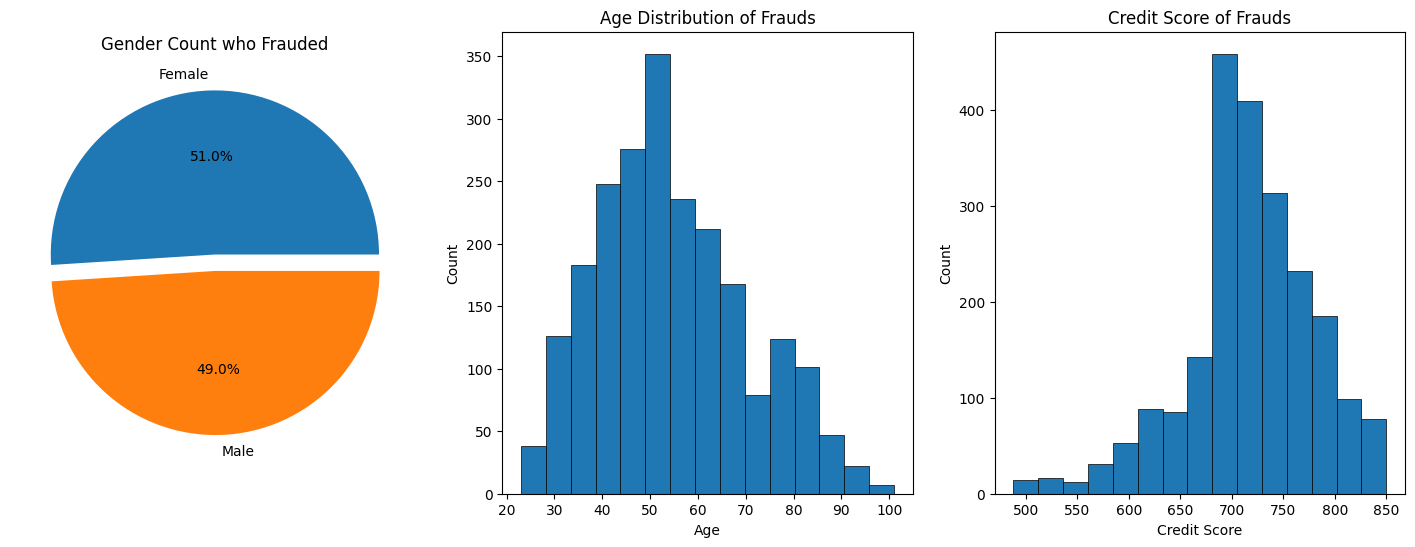

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))



labels = tuple(test_2["gender"].value_counts().keys())

nums = test_2["gender"].value_counts().values

ax1.pie(nums, labels=labels, autopct='%1.1f%%', explode=(0.05, 0.05))

ax1.set_title("Gender Count who Frauded")



ax2.hist(test_2["current_age"], bins=15, edgecolor="black", linewidth=0.5)

ax2.set_title("Age Distribution of Frauds")

ax2.set_xlabel("Age")

ax2.set_ylabel("Count")



ax3.hist(test_2["credit_score"], bins=15, edgecolor="black", linewidth=0.5)

ax3.set_title("Credit Score of Frauds")

ax3.set_xlabel("Credit Score")

ax3.set_ylabel("Count")

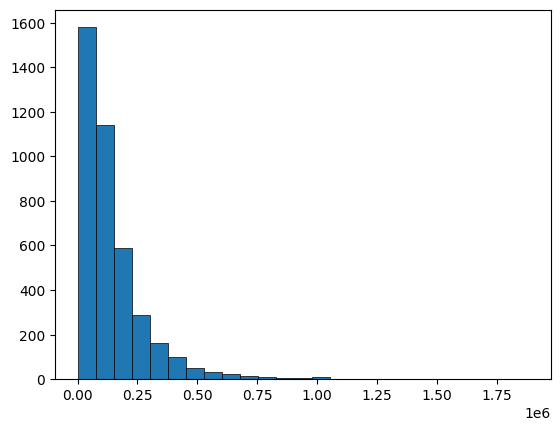

In [19]:
plt.hist(df_who_fraud["amount"], bins=25, edgecolor="black", linewidth=0.5)

plt.show()

In [20]:
# Who has spent at least $1 000 000???

df_who_fraud[df_who_fraud["amount"] >= 1000000]

amount
gender current_age address                num_cards credit_score per_capita_income yearly_income total_debt card_type card_number      card_id card_brand cvv acct_open_date expires              
Male   35          583 Seventh Street     1         642          50579.0           103126.0      130160.0   Credit    4000393241453107 4993    Visa       408 10-2003        10-2021  1.032708e+06
Female 63          4461 Hill Street       1         606          26339.0           53702.0       85160.0    Debit     5412731781518758 2408    Mastercard 599 04-2000        05-2018  1.181416e+06
Male   51          207 Ocean View Street  1         505          53790.0           109673.0      242379.0   Debit     5809446324429038 3239    Mastercard 480 06-2002        09-2020  1.590821e+06
Female 31          95410 Pine Boulevard   2         721          47408.0           96661.0       73401.0    Credit    4892840339331137 1195    Visa       127 02-2009        07-2024  1.086473e+06
Male   51          2003 Ninth Avenue      1         632          39495.0           80526.0       117380.0   Credit    6369515530338470 3130    Discover   852 05-2013        10-2024  1.004969e+06
Female 51          6840 North Lane        6         840          55274.0           112695.0      35135.0    Credit    364780102699868  2168    Amex       611 03-2008        12-2022  1.067734e+06
Male   34          927 River Street       2         745          15758.0           32126.0       54351.0    Debit     5304434448477779 5413    Mastercard 266 11-2004        12-2022  1.007283e+06
                   95266 Bayview Drive    3         694          52813.0           107683.0      225017.0   Debit     5803563077451662 5146    Mastercard 827 10-2009        11-2020  1.141463e+06
Female 52          25622 Lake Street      1         683          36253.0           73920.0       166395.0   Debit     5686575699244488 2530    Mastercard 666 04-2007        12-2024  1.037404e+06
Male   47          130 Lincoln Drive      3         693          21156.0           43133.0       44263.0    Credit    357731604070533  4938    Amex       270 10-1999        05-2020  1.019402e+06
       58          8996 Third Street      2         503          40694.0           82974.0       181429.0   Credit    4333340134035074 3530    Visa       27  06-2011        03-2024  1.009838e+06
       30          323 Eighth Drive       3         734          33151.0           67589.0       0.0        Debit     4817071694522158 1247    Visa       185 02-2010        06-2020  1.013482e+06
       36          2352 Bayview Boulevard 1         850          33078.0           67444.0       93513.0    Credit    352397360356465  3233    Amex       465 06-2002        08-2022  1.882899e+06
       33          632 Pine Drive         2         739          27474.0           56018.0       100163.0   Credit    4274011202694035 3450    Visa       289 06-2009        06-2022  1.297804e+06

# Analysis Summary

The number of fraudulent cases were very small. It can be seen that the number of transaction methods differ between those who did not commit fraud and those who did. Those who did not commit fraud performed few online transactions while many of those who did performed online transations. A lot of the card types used were Debit cards with some number of Credit cards. Mastercards and Visa cards were also used.



Many was spent on Department Stores, and the amount of money spent, regardless of what was spent on, were mainly items that were cheap. It is unclear what the deficit means at this time. It seems that most expensive item bought was from a Cruise Lines MCC, presumably a ticket for a cruise. Merchant ID is provided but the state and name are not provided as it was purchased online.



It also seems that those who are between 40 and 60 years old are the perpetrators of fraudulent transactions. It may be a possibility that their cards were stolen. The people who committed fraudulent transactions have been narrowed down by amount spent at leat $1 000 000, because the highest amount spent is more than $1 800 000. 